# ReconST Example: Gene Panel Selection

This notebook demonstrates using the ReconST package for optimal gene selection.

In [1]:
import os
import copy
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

import reconst
from reconst import FeatureScreeningAutoencoder, prepare_common_genes, create_data_loader
from reconst import train_model, evaluate_model, select_genes

/Users/hlu/Library/r-miniconda-arm64/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## 1. Load Data

## Note: Please download the processed example dataset from the following link, and put it under "software_ReconST/", as the file size is too large as supplementary file in submission system.

### Link: https://outlookuga-my.sharepoint.com/:f:/g/personal/hl25823_uga_edu/EtiBLZrtPPdHo2_vRc_pxOsBg838neP5wiQTvu8kar_DpQ?e=Ci9JF8 

In [ ]:
# Load scRNA-seq data
adata00 = sc.read_h5ad('../example_data/example_sc.h5ad')
adata01 = copy.deepcopy(adata00)

# Basic filtering
sc.pp.filter_cells(adata01, min_genes=200)
sc.pp.filter_genes(adata01, min_cells=100)

# Normalization
sc.pp.normalize_total(adata01, target_sum=1e4)

print(f'Number of cells after processing: {adata01.n_obs}')
print(f'Number of genes after processing: {adata01.n_vars}')

# Get gene identifiers
gene_identifier_1 = adata01.var_names.tolist()

In [ ]:
# Load MERFISH data
MER_cell_metadata   = pd.read_csv("../example_data/example_merfish_cell_metadata.csv")
MER_ccf_coordinates = pd.read_csv("../example_data/example_merfish_ccf_coordinates.csv")
MER_gene            = pd.read_csv("../example_data/example_merfish_gene.csv")
MER_adata = sc.read_h5ad("../example_data/example_merfish.h5ad")

gene_identifier_2 = MER_gene['gene_identifier']

print(f'MERFISH - Cells: {MER_adata.n_obs}, Genes: {MER_adata.n_vars}')

MERFISH - Cells: 215278, Genes: 1122


## 2. Preprocess: Find Common Genes

In [4]:
# Find common genes between scRNA-seq and MERFISH data
adata01_common, MER_adata_common, common_genes = prepare_common_genes(adata01, MER_adata)

print(f"Number of genes in data 1: {len(gene_identifier_1)}")
print(f"Number of genes in data 2: {len(gene_identifier_2)}")
print(f'Number of common genes: {len(common_genes)}')
print(f'scRNA-seq: {adata01_common.n_obs} cells, {adata01_common.n_vars} genes')
print(f'MERFISH: {MER_adata_common.n_obs} cells, {MER_adata_common.n_vars} genes')

Number of genes in data 1: 18873
Number of genes in data 2: 1122
Number of common genes: 1014
scRNA-seq: 44310 cells, 1014 genes
MERFISH: 215278 cells, 1014 genes


## 3. Prepare Data Loaders

In [5]:
# Create data loaders for training (scRNA-seq)
train_loader, test_loader_sc = create_data_loader(adata01_common, batch_size=256, train_split=0.8)

# Create test loader for MERFISH
from reconst.data import GeneExpressionDataset
from torch.utils.data import DataLoader

matrix = MER_adata_common.X.toarray() if hasattr(MER_adata_common.X, "toarray") else MER_adata_common.X
merfish_dataset = GeneExpressionDataset(torch.tensor(matrix, dtype=torch.float32))
test_loader_merfish = DataLoader(merfish_dataset, batch_size=256, shuffle=False)

## 4. Train Model

In [8]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = adata01_common.n_vars
embedding_size = 200

model = FeatureScreeningAutoencoder(input_size, embedding_size, dp=0.05, lk=0.3).to(device)

# Create results directory
os.makedirs("./results", exist_ok=True)

# Train
train_losses, test_losses = train_model(
    model, train_loader, test_loader_sc, 
    num_epochs=20, lr=1e-3, weight_decay=1e-5, l_lambda=1e-4, device=device
)

# Save the trained model
torch.save(model.state_dict(), './results/autoencoder_common_genes.pth')
print("Model saved to './results/autoencoder_common_genes.pth'")

Epoch [1/20], Train: 0.4225, Test: 0.3557
Epoch [2/20], Train: 0.3378, Test: 0.3255
Epoch [3/20], Train: 0.3168, Test: 0.3094
Epoch [4/20], Train: 0.3039, Test: 0.2988
Epoch [5/20], Train: 0.2953, Test: 0.2921
Epoch [6/20], Train: 0.2887, Test: 0.2854
Epoch [7/20], Train: 0.2836, Test: 0.2817
Epoch [8/20], Train: 0.2798, Test: 0.2782
Epoch [9/20], Train: 0.2768, Test: 0.2757
Epoch [10/20], Train: 0.2741, Test: 0.2730
Epoch [11/20], Train: 0.2716, Test: 0.2714
Epoch [12/20], Train: 0.2695, Test: 0.2692
Epoch [13/20], Train: 0.2676, Test: 0.2679
Epoch [14/20], Train: 0.2659, Test: 0.2667
Epoch [15/20], Train: 0.2645, Test: 0.2654
Epoch [16/20], Train: 0.2633, Test: 0.2643
Epoch [17/20], Train: 0.2625, Test: 0.2638
Epoch [18/20], Train: 0.2616, Test: 0.2632
Epoch [19/20], Train: 0.2605, Test: 0.2629
Epoch [20/20], Train: 0.2598, Test: 0.2622
Model saved to './results/autoencoder_common_genes.pth'


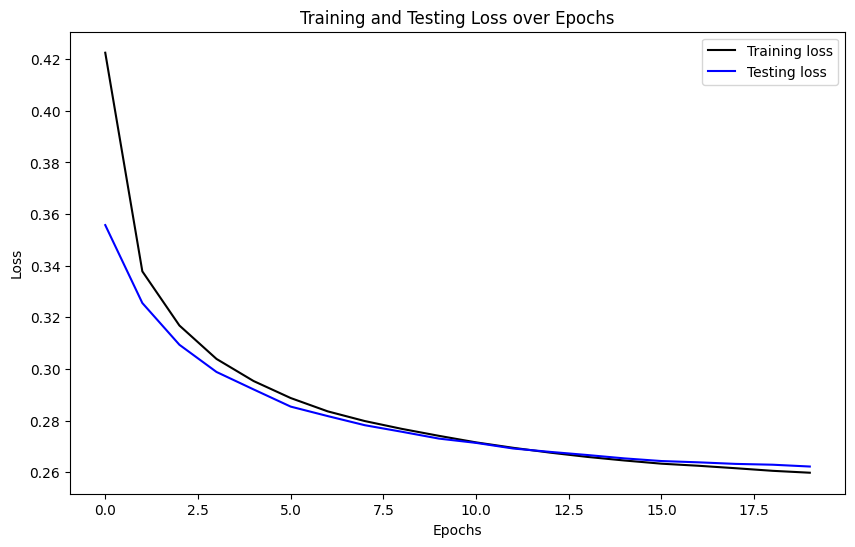

Final training loss:  0.25980988693705426
Final testing loss:  0.26220912837573246


In [9]:
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training loss', color='black')
plt.plot(test_losses, label='Testing loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.savefig('./results/loss_curve_common_genes.png')
plt.show()

print("Final training loss: ", train_losses[-1])
print("Final testing loss: ", test_losses[-1])

## 5. Gene Selection and Evaluation

In [10]:
# Select genes based on importance threshold
genes_mask, feature_importances = select_genes(model, threshold=0.001)

print(f'Selected genes: {np.sum(genes_mask)}/{len(genes_mask)}')

Selected genes: 395/1014


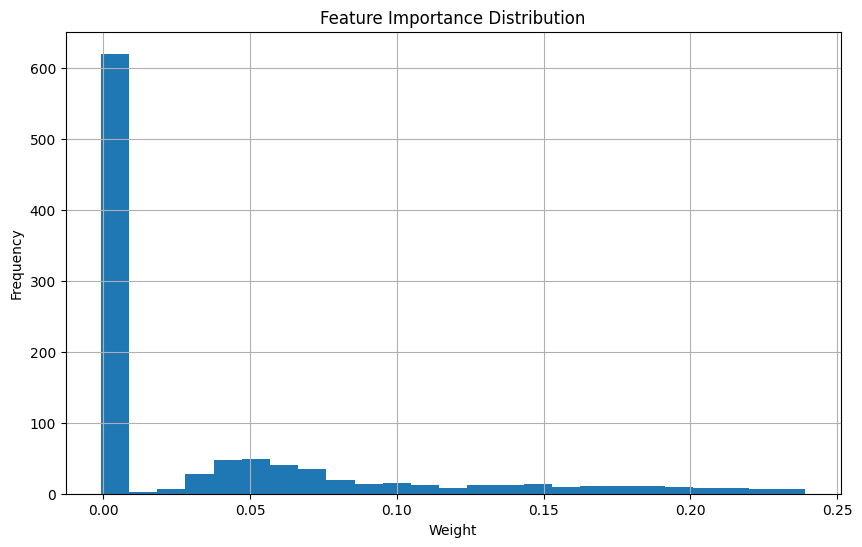

In [11]:
# Plot feature importance distribution
plt.figure(figsize=(10, 6))
plt.hist(feature_importances, bins=25)
plt.title('Feature Importance Distribution')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
# Evaluate on MERFISH data
loss_all = evaluate_model(model, test_loader_merfish, gene_mask=None, device=device)
loss_selected = evaluate_model(model, test_loader_merfish, gene_mask=genes_mask, device=device)

print(f'Test Loss (all genes): {loss_all:.4f}')
print(f'Test Loss (selected genes): {loss_selected:.4f}')

Test Loss (all genes): 0.1660
Test Loss (selected genes): 0.1660


In [13]:
# Get selected gene symbols
selected_gene_symbols = adata01_common.var['gene_symbol'][genes_mask].tolist()
all_gene_symbols = adata01_common.var['gene_symbol']

print(f'Number of selected genes: {len(selected_gene_symbols)}')
print('Sample genes:', selected_gene_symbols[:10] if len(selected_gene_symbols) >= 10 else selected_gene_symbols)

Number of selected genes: 395
Sample genes: ['Oprk1', 'St18', 'Eya1', 'Col19a1', 'Pou3f3', 'Satb2', 'Erbb4', 'Spag16', 'Vwc2l', 'Tns1']


In [14]:
# Save results
df_importances = pd.DataFrame({
    'gene_symbol': all_gene_symbols.values,
    'importance': feature_importances
})
df_importances.to_csv('./results/feature_importances.csv', index=False)
print("Saved feature importances to './results/feature_importances.csv'")

df_selected = pd.DataFrame({'filtered_gene_symbol': selected_gene_symbols})
df_selected.to_csv('./results/filtered_gene_symbols.csv', index=False)
print("Saved filtered gene symbols to './results/filtered_gene_symbols.csv'")

Saved feature importances to './results/feature_importances.csv'
Saved filtered gene symbols to './results/filtered_gene_symbols.csv'
